# gridfinder
Run through the full gridfinder model from data input to final guess

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
import rasterio
import geopandas as gpd

from gridfinder._util import save_raster, clip_line_poly
from gridfinder.prepare import clip_rasters, merge_rasters, create_filter, prepare_ntl, prepare_roads
from gridfinder.gridfinder import get_targets_costs, estimate_mem_use, optimise
from gridfinder.post import threshold, accuracy, guess2geom

## Set folders and parameters

In [3]:
country = 'burundi'

folder = Path(f'results/{country}')
folder_ntl = folder / 'NTL_clipped'
aoi_in = folder / f'gadm_{country}.gpkg'
roads_in = folder / f'roads_{country}.gpkg'
grid_truth = folder / f'grid_{country}.gpkg'

raster_merged_out = folder / 'ntl_merged.tif'
targets_out = folder / 'ntl.tif'
roads_out = folder / 'roads_raster.tif'

dist_out = folder / 'dist.tif'
guess_out = folder / 'guess.tif'
guess_vec_out = folder / 'guess.gpkg'

## Clip  and merge monthly rasters

In [4]:
clip_rasters(folder_ntl, folder_ntl, aoi_in)

Doing VIIRS_2016_03.tif
Doing VIIRS_2016_09.tif
Doing VIIRS_2016_05.tif
Doing VIIRS_2016_01.tif
Doing VIIRS_2016_04.tif
Doing VIIRS_2016_02.tif
Doing VIIRS_2016_08.tif
Doing VIIRS_2016_11.tif
Doing VIIRS_2016_06.tif
Doing VIIRS_2016_07.tif
Doing VIIRS_2016_12.tif
Doing VIIRS_2016_10.tif


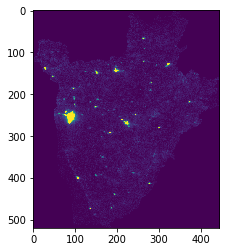

In [5]:
raster_merged, affine = merge_rasters(folder_ntl, percentile=70)
save_raster(raster_merged_out, raster_merged, affine)
plt.imshow(raster_merged, vmin=0, vmax=1)

## Create filter

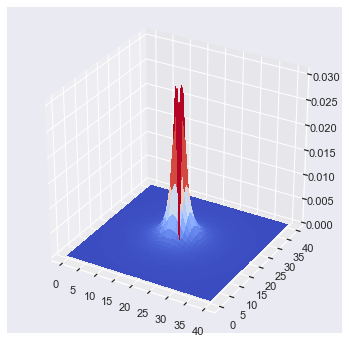

In [6]:
ntl_filter = create_filter()

X = np.fromfunction(lambda i, j: i, ntl_filter.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.shape)

fig = plt.figure(figsize=(6,6))
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Clip, filter and resample NTL

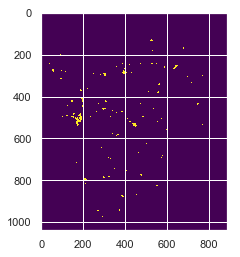

In [7]:
_, _, _, ntl_thresh, affine = prepare_ntl(raster_merged_out,
                                          aoi_in,
                                          ntl_filter=ntl_filter,
                                          threshold=2.1,
                                          upsample_by=2)
save_raster(targets_out, ntl_thresh, affine)
plt.imshow(ntl_thresh, cmap='viridis')

## Roads: assign values, clip and rasterize

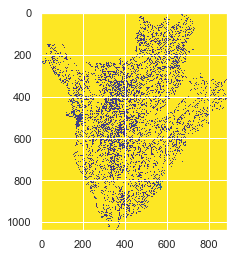

In [8]:
_, _, _, roads_raster, affine = prepare_roads(roads_in,
                                              aoi_in,
                                              targets_out)
save_raster(roads_out, roads_raster, affine)
plt.imshow(roads_raster, cmap='viridis', vmin=0, vmax=1)

## Get targets and costs and run algorithm

In [9]:
targets, costs, start, affine = get_targets_costs(targets_out, roads_out)
est_mem = estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.02 GB


In [10]:
dist = optimise(targets, costs, start, jupyter=True)

'99.00 %'

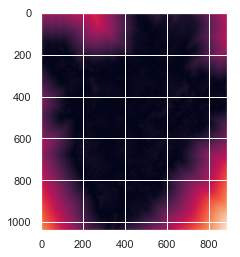

In [11]:
save_raster(dist_out, dist, affine)
plt.imshow(dist)

## Filter dist results to grid guess

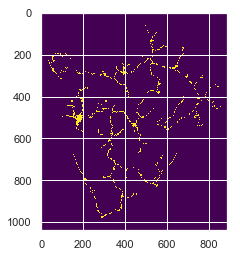

In [12]:
_, guess, transform = threshold(dist_out, cutoff=0.5)
save_raster(guess_out, guess, transform)
plt.imshow(guess, cmap='viridis')

## Check results

In [13]:
true_pos, false_neg = accuracy(grid_truth, guess_out, aoi_in)
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

Points identified as grid that are grid: 39%
Actual grid that was missed: 38%


## Convert to geometry
To create line geometry, follow these steps in QGIS using guess.tif created above.
1. Translate (convert format) - Output data type: Int32  
2. r.null - List of values to be set to NULL: 0
3. r.thin - Default values
4. r.to.vect - Feature type: line

/home/chris/.envs/gridfinder/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


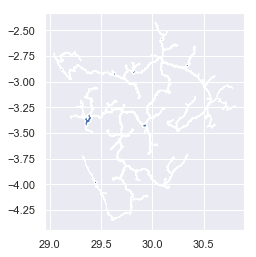

In [14]:
_, _, guess_gdf = guess2geom(guess_out)
guess_gdf.to_file(guess_vec_out, driver='GPKG')
guess_gdf.plot()